# Import libraries

In [1]:
import sys
sys.path.append("../")
from ortho_lib import *
from scipy.stats import entropy
from scipy.signal import correlate2d
import pandas as pd
from scipy.spatial.transform import Rotation as R
import math

# Define Euler function (from rotation matrix (3x3) to Euler angles (1x3)) 

In [2]:
def calculate_euler(x0, x1, x2, y0, y1, y2, z0, z1, z2):
    r = R.from_matrix([[x0, y0, z0],
                  [x1, y1, z1],
                  [x2, y2, z2]])
    Z1, X, Z2 = r.as_euler('ZXZ', degrees=True)
    return Z1, X, Z2

# Define function to retreive specific version of an exercise

In [3]:
def get_exercises_from_category(patient_ids):
    exerciseAB1 = {}

    for p in patient_ids:
        AB = files_category.get_exercises(p, ex_type='AB')
        AB1 = AB[0]
        exerciseAB1[p] = AB1

    return exerciseAB1

# Define function to create usable dataframe

In [4]:
def get_df_dicts_rotation(files_category, exerciseAB1):
    df_dicts = {}

    for i, value in exerciseAB1.items():
        path = files_category.fullpath(pat_id = i, exercise = value)
        df_with_rotation = exercise_to_df_with_rotation(path).reset_index(drop=True)
        if df_with_rotation['frame'].max() > 200:
            continue
        df_dicts[i] = df_with_rotation

    return df_dicts

# Define function to create dictionary with Euler angles

In [ ]:
def get_dict_euler_left(df_dicts):

    dict_euler = {}
    for p, df in df_dicts.items():

        df_shoulder_left = df[df['sensor'] == '4']

        Z1_list = []
        X_list = []
        Z2_list = []
        for index, row in df_shoulder_left.iterrows():
            x0, x1, x2, y0, y1, y2, z0, z1, z2 = row[['x0', 'x1', 'x2', 'y0', 'y1', 'y2', 'z0', 'z1', 'z2']]
            Z1, X, Z2 = calculate_euler(x0, x1, x2, y0, y1, y2, z0, z1, z2)
            Z1_list.append(Z1)
            X_list.append(X)
            Z2_list.append(Z2)

        df_shoulder_left['Z1_angle'] = Z1_list
        df_shoulder_left['X_angle'] = X_list
        df_shoulder_left['Z2_angle'] = Z2_list

        df_shoulder_left.reset_index(inplace=True, drop=True)
        dict_euler[p] = df_shoulder_left
    return dict_euler

# Get and prepare data

In [6]:
directory = '..//transformed_data/'
category = ['Category_1', 'Category_3']
exercise = 'AB1'

dict_euler_dfs = {}
for c in category:
    file = os.path.join(directory, c)
    files_category = FilesCategory(file)
    patient_ids = sorted(files_category.get_patient_ids())
    
    exerciseAB1 = get_exercises_from_category(patient_ids)
    df_dicts = get_df_dicts_rotation(files_category, exerciseAB1)
    dict_euler_dfs[c] = get_dict_euler_left(df_dicts)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

# Plot information calculated in functions

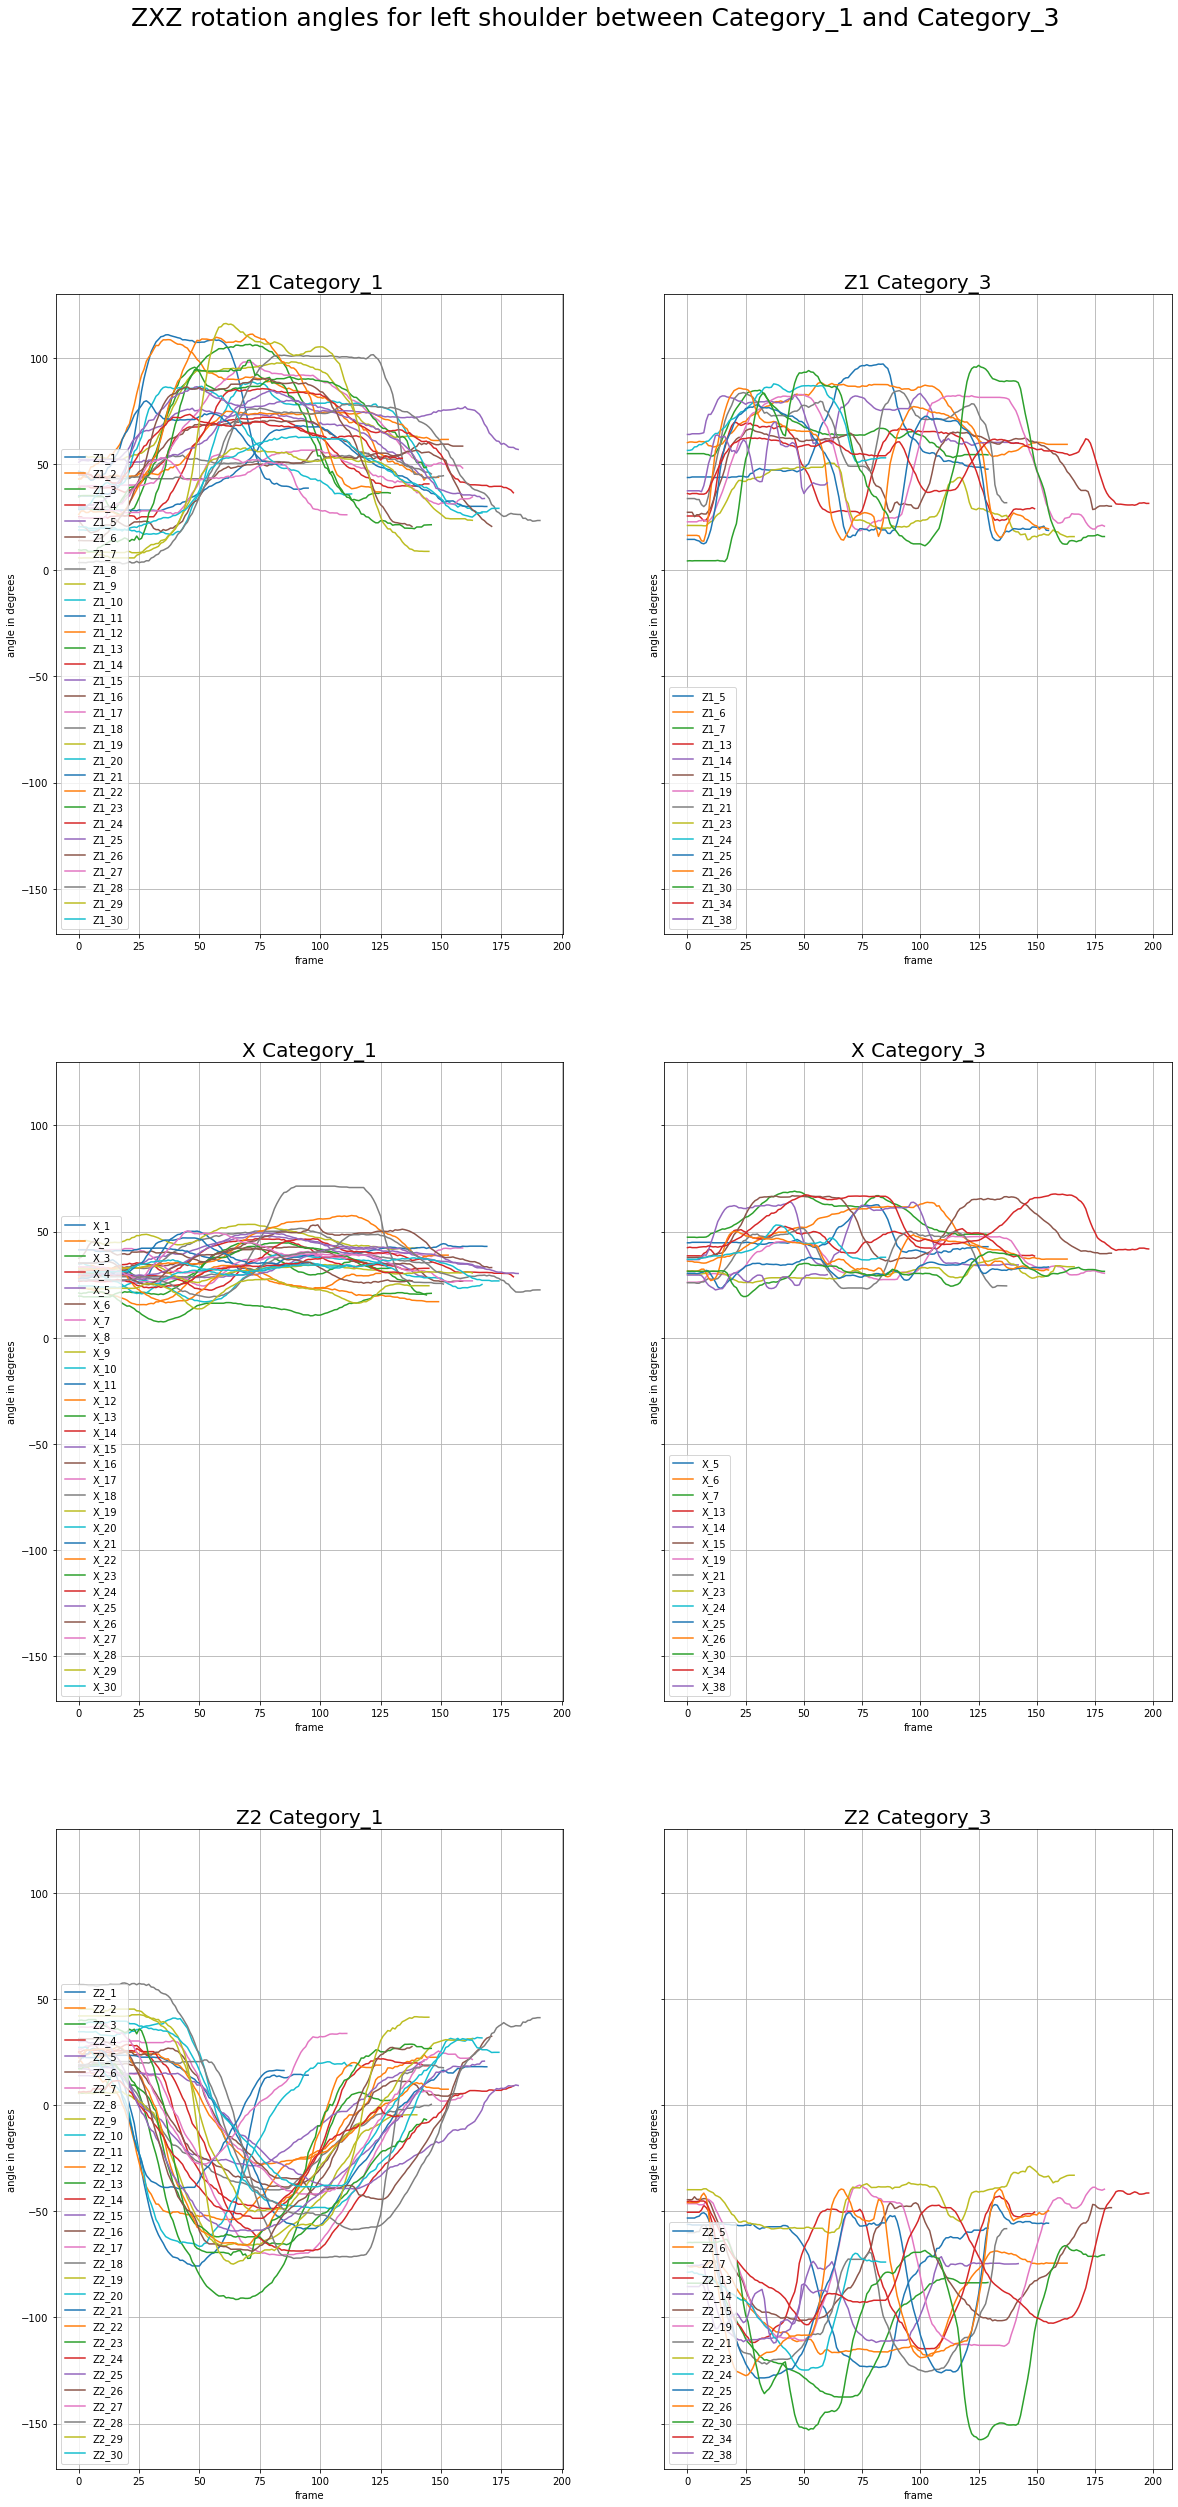

In [7]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(20,40))

for p, df in dict_euler_dfs[category[0]].items():
    axs[0,0].plot(df['frame'], df['Z1_angle'], label=('Z1_'+ str(p)))    
    axs[0,0].set_title('Z1 ' + category[0], fontsize=20)
    axs[1,0].plot(df['frame'], df['X_angle'], label=('X_' + str(p)))
    axs[1,0].set_title('X ' + category[0], fontsize=20)
    axs[2,0].plot(df['frame'], df['Z2_angle'], label=('Z2_'+ str(p)))
    axs[2,0].set_title('Z2 ' + category[0], fontsize=20)
    
for p, df in dict_euler_dfs[category[1]].items():
    axs[0,1].plot(df['frame'], df['Z1_angle'], label=('Z1_'+ str(p))) 
    axs[0,1].set_title('Z1 ' + category[1], fontsize=20)
    axs[1,1].plot(df['frame'], df['X_angle'], label=('X_' + str(p)))
    axs[1,1].set_title('X ' + category[1], fontsize=20)
    axs[2,1].plot(df['frame'], df['Z2_angle'], label=('Z2_'+ str(p)))
    axs[2,1].set_title('Z2 ' + category[1], fontsize=20)

#ax2.get_shared_y_axes().join(ax2, ax4)

fig.suptitle('ZXZ rotation angles for left shoulder between ' + category[0] + ' and ' + category[1], fontsize=25)

for ax in axs.flat:
    ax.set(xlabel='frame', ylabel='angle in degrees')

for row in axs:
    for ax in row:
        ax.grid()
        ax.legend(loc=3)
